In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import hyp2f1
from scipy.stats import norm

In [2]:
n = 200

repeat = 10000

# Zn1 has shape (repeat, n)
Zn1 = np.random.multivariate_normal(
        np.zeros(n), np.eye(n), repeat)  # une fois pour tout (invariant by eta and lam)
Zn2 = np.random.multivariate_normal(
        np.zeros(n), np.eye(n), repeat)

w1 = np.cumsum(Zn1, axis=1)
w2 = np.cumsum(Zn2, axis=1)

In [3]:
# Gaussian distributions, as reference
N_prime = norm.pdf
N = norm.cdf


def black_scholes_call(S, K, T, r, sigma):
    """

    :param S: Asset price
    :param K: Strike price
    :param T: Time to maturity
    :param r: risk-free rate (treasury bills)
    :param sigma: volatility
    :return: call price
    """

    # standard black-scholes formula
    d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    call = S * N(d1) - N(d2) * K * np.exp(-r * T)
    return call


def vega(S, K, T, r, sigma):
    """

    :param S: Asset price
    :param K: Strike price
    :param T: Time to Maturity
    :param r: risk-free rate (treasury bills)
    :param sigma: volatility
    :return: partial derivative w.r.t volatility
    """

    # calculating d1 from black scholes
    d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / sigma * np.sqrt(T)

    # see hull derivatives chapter on greeks for reference
    vega = S * N_prime(d1) * np.sqrt(T)
    return vega


def implied_volatility_call_newton(C, S, K, T, r, tol=0.0001, max_iterations=100):
    """

    :param C: Observed call price
    :param S: Asset price
    :param K: Strike Price
    :param T: Time to Maturity
    :param r: riskfree rate
    :param tol: error tolerance in result
    :param max_iterations: max iterations to update vol
    :return: implied volatility in percent
    """

    # assigning initial volatility estimate for input in Newton_rap procedure
    sigma = 0.3
    eps = np.finfo(float).eps
    for i in range(max_iterations):

        # calculate difference between blackscholes price and market price with
        # iteratively updated volality estimate
        diff = black_scholes_call(S, K, T, r, sigma) - C

        # break if difference is less than specified tolerance level
        if abs(diff) < tol:
            break

        # use newton rapshon to update the estimate
        sigma = sigma - diff / (eps+vega(S, K, T, r, sigma))

    return sigma


def implied_volatility_call_bisection(C, S, K, T, r, tol=0.0001, max_iterations=100):
    """

    :param C: Observed call price
    :param S: Asset price
    :param K: Strike Price
    :param T: Time to Maturity
    :param r: riskfree rate
    :param tol: error tolerance in result
    :param max_iterations: max iterations to update vol
    :return: implied volatility in percent
    """

    # assigning initial volatility estimate for input in Newton_rap procedure
    a = 0
    b = 1
    sigma = 0.5

    for i in range(max_iterations):

        # calculate difference between blackscholes price and market price with
        # iteratively updated volality estimate
        diff = black_scholes_call(S, K, T, r, sigma) - C

        # break if difference is less than specified tolerance level
        if abs(diff) < tol:
            break

        # use bisection method to update the estimate
        if diff < 0:
            if black_scholes_call(S, K, T, r, b) < C:
                a = b
                b = 2 * b
            a = sigma
            sigma = 0.5 * (a + b)
        if diff > 0:
            b = sigma
            sigma = 0.5 * (a + b)

    return sigma


def hallerbach_approximation(C, S, K, T, r):

    X = K * np.exp(-r * T)
    sigma = (1 / np.sqrt(T) * np.sqrt(2 * np.pi) / (2 * (S + X))) * (
        2 * C
        + X
        - S
        + np.sqrt(
            (2 * C + X - S) ** 2
            - 1.85 * (S + X) * (X - S) ** 2 / (np.pi * np.sqrt(X * S))
        )
    )
    # print((2 * C + X - S) ** 2 - 2 * (S + X) * (X - S) ** 2 / (S * np.pi))

    return sigma


In [4]:
# Exp Kernel-Cholesky for XT

def Sigma_exp(t, s, eta, lam):
    return (
        eta**2
        / (2 * lam)
        * np.exp(-lam * (s + t))
        * (np.exp(2 * lam * np.minimum(s, t)) - 1)
    )

def covariance_exp(T, eta, lam):
    '''Return the covariance Sigma for exponential kernel.
    '''
    times = np.linspace(0, T, n + 1)
    cov = np.zeros((n, n))
    for i in range(n):
        cov[i, :] = Sigma_exp(times[1+i], times[1:], eta=eta, lam=lam)
    return cov


In [5]:
# Frac Kernel-XT

def aux_integral_function(x,k,a):
    return x*(k+x**2)**a*((k+x**2)/k)**(-a)*hyp2f1(0.5, -a, 1.5, -x**2/k)

def Sigma_frac(t, s, H, c):
    a = H-0.5
    if t==s:
        return c**2 * 2*(t/2)**(2*a+1)/(2*a+1)
    else:
        k = 0.25*(s-t)**2
        xmin = - 0.5*(s+t)
        xmax = np.minimum(t,s) + xmin
        return c**2 * (aux_integral_function(xmax, k, a) - aux_integral_function(xmin, k, a))

def covariance_frac(T, H, c):
    times = np.linspace(0, T, n + 1)
    cov = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            cov[i,j] = Sigma_frac(times[1+i], times[1+j], H=H, c=c)
    return cov


In [6]:

def sample_XT_Cholesky(lam, eta, Zns=Zn1, T=1.5):

    cov = covariance_exp(eta=eta, lam=lam, T=T)
    L = np.linalg.cholesky(cov)
    # t begins from t1=T/n but not t0=0
    sample = Zns @ L.T

    # mean = np.mean(sample[:, -1])
    # var = np.var(sample[:, -1])
    # demi_width_IC = np.sqrt(var/repeat) * 1.96
    
    # print(f"X_T: mean={mean:3.3f} var={var:3.3f} ({Sigma_exp(t=T,s=T, eta=eta, lam=lam):3.3f})")
    # print("IC(95%%) = [%1.3f, %1.3f] \n" \
    #   %(mean-demi_width_IC, mean + demi_width_IC))
    
    return sample, cov

def sample_XT_cumsum(lam, eta, Zns=Zn1, T=1.5):
    times = np.linspace(0, T, n + 1)
    sigma = eta * np.sqrt(np.exp(2*lam*times[:-1])*(np.exp(2*lam*T/n)-1)/(2*lam))
    sample = np.exp(-lam*times[1:]) * np.cumsum(Zns*sigma, axis=1)

    # mean = np.mean(sample[:, -1])
    # var = np.var(sample[:, -1])
    # demi_width_IC = np.sqrt(var/repeat) * 1.96
    
    # print(f"X_T: mean={mean:3.3f} var={var:3.3f} ({Sigma_exp(t=T,s=T, eta=eta, lam=lam):3.3f})")
    # print("IC(95%%) = [%1.3f, %1.3f] \n" \
    #   %(mean-demi_width_IC, mean + demi_width_IC))
    
    return sample
    

def sample_XT_frac(H, c, Zns=Zn1, T=1.5):

    cov = covariance_frac(T=T, H=H, c=c)
    L = np.linalg.cholesky(cov)
    
    sample =  Zns @ L.T

    # mean = np.mean(sample[:, -1])
    # var = np.var(sample[:, -1])
    # demi_width_IC = np.sqrt(var/repeat) * 1.96
    
    # print(f"X_T: mean={mean:3.3f} var={var:3.3f} ({Sigma_frac(T,T, H, c):3.3f})")
    # print("IC(95%%) = [%1.3f, %1.3f] \n" \
    #   %(mean-demi_width_IC, mean + demi_width_IC))
    
    return sample, cov

In [7]:
%%timeit
sample_XT_cumsum(lam=1, eta=1)

21.9 ms ± 2.75 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
%%timeit
sample_XT_Cholesky(lam=1, eta=1)

5.95 ms ± 137 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
def plot_sample(sample, ylabel="${X_T}$", title=f"Sample of XT with n={n}", save_pic=False):
    T=1.5
    times = np.linspace(0, T, n + 1)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(times[1:], sample.T, "-")

    ax.set_xlabel("time t")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.show()
    if save_pic:
        plt.savefig(title)

In [9]:
def sample_B(rho=0.5, T=1.5):
    sample = rho*np.sqrt(T/n)*w1+np.sqrt(1-rho**2)*np.sqrt(T/n)*w2
    
    mean = np.mean(sample[:, -1])
    var = np.var(sample[:, -1])
    demi_width_IC = np.sqrt(var/repeat) * 1.96
    
    # print(f"B_T: mean={mean:3.3f} var={var:3.3f} ({T:3.3f})")
    # print("IC(95%%) = [%1.3f, %1.3f] \n" \
    #   %(mean-demi_width_IC, mean + demi_width_IC))
    
    return sample

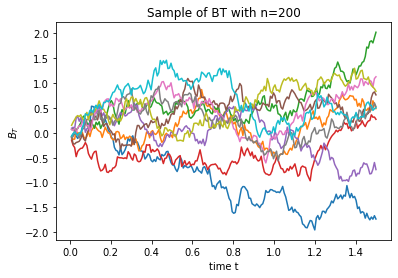

In [12]:
plot_sample(sample_B(rho=0)[:10], ylabel="${B_T}$", title=f"Sample of BT with n={n}")
print("")

In [10]:
def Sigma(X, vars, ksi=0.5, a0=1, a1=1):
    return ksi*(a0 + a1*X) / np.sqrt(a0**2 + a1**2*vars)

In [11]:
def sample_S_exp(rho=0.5, eta=1, lam=1, S0=100, ksi=0.5, a0=1, T=1.5):
    
    X_sample, cov = sample_XT_Cholesky(lam=lam, eta=eta, T=T)
    vars = np.diagonal(cov)

    sigma = np.hstack((np.zeros(repeat).reshape(-1,1), Sigma(X_sample, vars, ksi=ksi, a0=a0)))
    

    B_sample =  np.hstack((np.zeros(repeat).reshape(-1,1), sample_B(rho=rho,T=T)))
    sum1 = np.cumsum(0.5*(sigma[:, :-1]**2+sigma[:, 1:]**2)*T/n, axis=1)
    sum2 = np.cumsum((sigma[:, :-1])*(B_sample[:, 1:]-B_sample[:,:-1]), axis=1)
    sample = np.hstack((S0*np.ones(repeat).reshape(-1,1), S0*np.exp(-0.5*sum1+sum2)))
    
    # mean = np.mean(sample[:, -1])
    # var = np.var(sample[:, -1])
    # demi_width_IC = np.sqrt(var/repeat) * 1.96
    # print(f"S_T: mean={mean:3.3f} var={var:3.3f}")
    # print("IC(95%%) = [%1.3f, %1.3f] \n" \
    #   %(mean-demi_width_IC, mean + demi_width_IC))
         
    return sample

def sample_S_frac(rho=0.5, H=0.5, c=1, S0=100, ksi=0.5, a0=1, T=1.5):
    
    X_sample, cov = sample_XT_frac(H=H, c=c, T=T)
    vars = np.diagonal(cov)

    sigma = np.hstack((np.zeros(repeat).reshape(-1,1), Sigma(X_sample, vars, ksi=ksi, a0=a0)))

    B_sample =  np.hstack((np.zeros(repeat).reshape(-1,1), sample_B(rho=rho,T=T)))
    sum1 = np.cumsum(0.5*(sigma[:, :-1]**2+sigma[:, 1:]**2)*T/n, axis=1)
    sum2 = np.cumsum((sigma[:, :-1])*(B_sample[:, 1:]-B_sample[:,:-1]), axis=1)
    sample = np.hstack((S0*np.ones(repeat).reshape(-1,1), S0*np.exp(-0.5*sum1+sum2)))
    
    # mean = np.mean(sample[:, -1])
    # var = np.var(sample[:, -1])
    # demi_width_IC = np.sqrt(var/repeat) * 1.96
    # print(f"S_T: mean={mean:3.3f} var={var:3.3f}")
    # print("IC(95%%) = [%1.3f, %1.3f] \n" \
    #   %(mean-demi_width_IC, mean + demi_width_IC))
         
    return sample

(10000, 201)


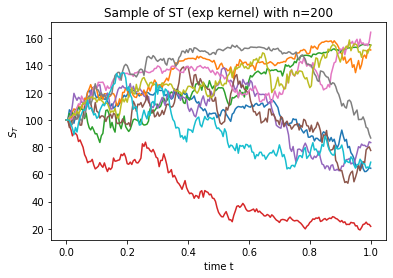

In [15]:
T = 1
times = np.linspace(0, T, n + 1)
sample = sample_S_exp(rho=-0.8, T=T)
print(sample.shape)
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(times, sample[:10].T, "-")

ax.set_xlabel("time t")
ax.set_ylabel("${S_T}$")
ax.set_title(f"Sample of ST (exp kernel) with n={n}")
plt.show()


(10000, 201)


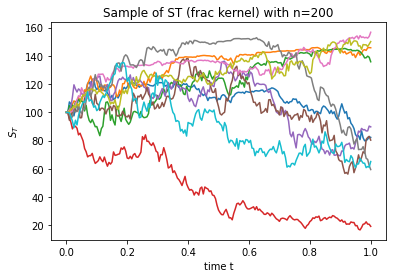

In [16]:
T = 1
times = np.linspace(0, T, n + 1)
sample = sample_S_frac(rho=-0.8, T=T)
print(sample.shape)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(times, sample[:10].T, "-")

ax.set_xlabel("time t")
ax.set_ylabel("${S_T}$")
ax.set_title(f"Sample of ST (frac kernel) with n={n}")
plt.show()

In [12]:
def call_exp(S0, K, T, rho=0.5, eta=1, lam=1):
    return np.mean(np.maximum(sample_S_exp(rho=rho, eta=eta, lam=lam, S0=S0, T=T)[:,-1]-K, 0))

In [13]:
def call_frac(S0, K, T, rho=0.5, H=0.5, c=1, ksi=0.5, a0=1):
    return np.mean(np.maximum(sample_S_frac(rho=rho, H=H, c=c, S0=S0, ksi=ksi, a0=a0, T=T)[:,-1]-K, 0))

In [19]:
%%time
# Here we calibrate using scipy.optimize for one slice

from scipy.optimize import minimize

# x0 = [-0.75, 0.25, 1, 0.5, 1]
x0 = [-0.7, 0.25, 0.5, 1, 0.5]

bounds = ((-1,-0.5),(0,0.5),(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf))

C = call_frac(S0=120, K=100, T=1.5, rho=-0.75, H=0.3, c=0.5, ksi=1, a0=0.5)

def call_frac_optimize(x, S0=120, K=100, T=1.5):
    ''' Objective function '''
    return np.abs(call_frac(K=K, S0=S0, T=T, rho=x[0], H=x[1], c=x[2], ksi=x[3], a0=x[4]) - C)


res = minimize(call_frac_optimize, x0, method='SLSQP', bounds=bounds)
print(res)
params = res.x
print(call_frac(S0=120, K=100, T=1.5, rho=params[0], H=params[1], c=params[2], ksi=params[3], a0=params[4]))
print(call_frac(S0=120, K=100, T=1.5, rho=-0.75, H=0.3, c=0.5, ksi=1, a0=0.5))

KeyboardInterrupt: 

In [42]:
%%time
# Here we calibrate using scipy.optimize for plural slices
from scipy.optimize import least_squares


def loss_1(x, K, y, S0, T, kernel: str):
    ''' loss function 
        x: input-x0=K, x1=S0, x2=T
        u: parameters-rho, H, c, ksi, a0
        y: the real call price
        kernel: type of kernel-'frac' or 'exp'
    '''
    if kernel=='frac':
        ST = sample_S_frac(S0=S0, T=T, rho=x[0], H=x[1], c=x[2], ksi=x[3], a0=x[4])[:,-1]
    
    if kernel=='exp':
        ST = sample_S_exp(S0=S0, T=T, rho=x[0], lam=x[1], eta=x[2], ksi=x[3], a0=x[4])[:,-1]
    
    return np.array([np.mean(np.maximum(ST-K[i], 0))-y[i] for i in range(len(y))])

def loss_2(x, K, y, S0, T, kernel: str):
    ''' loss function 
        x: input-x0=K, x1=S0, x2=T
        u: parameters-rho, H, c, ksi, a0
        y: the real call price
        kernel: type of kernel-'frac' or 'exp'
    '''
    if kernel=='frac':
        ST = sample_S_frac(S0=S0, T=T, rho=x[0], H=x[1], c=x[2], ksi=x[3], a0=x[4])[:,-1]
    
    if kernel=='exp':
        ST = sample_S_exp(S0=S0, T=T, rho=x[0], lam=x[1], eta=x[2], ksi=x[3], a0=x[4])[:,-1]
    
    return np.array([implied_volatility_call_newton(C=np.mean(np.maximum(ST-K[i], 0)),
                                                    S=S0,
                                                    K=K[i],
                                                    T=T,
                                                    r=0
                                                    ) 
                     - implied_volatility_call_newton(C=y[i],
                                                    S=S0,
                                                    K=K[i],
                                                    T=T,
                                                    r=0
                                                    )
                     for i in range(len(y))])


def calibration(Ks, y, S0, T, kernel="frac", x0=np.array([-0.7, 0.25, 0.5, 0.2, 0.5]), bounds=([-1, 0, 0, 0, 0], [-0.5, 0.5, 2, 2, 2]), loss=loss_1):
    return least_squares(loss, x0, bounds=bounds, args=(Ks, y, S0, T, kernel), ftol=1e-9, xtol=1e-9, gtol=1e-9, verbose=2)

CPU times: user 33 µs, sys: 2 µs, total: 35 µs
Wall time: 42.4 µs


In [31]:
Ks=np.arange(80,122,2)
y = np.array([call_frac(S0=100, K=Ks[i], T=1.5, rho=-0.75, H=0.3, c=0.5, ksi=1, a0=0.5) for i in range(len(Ks))])

res = calibration(Ks, y, S0=100, T=1.5)
print(res)
params = res.x
print(call_frac(S0=100, K=100, T=1.5, rho=params[0], H=params[1], c=params[2], ksi=params[3], a0=params[4]))
print(call_frac(S0=100, K=100, T=1.5, rho=-0.75, H=0.3, c=0.5, ksi=1, a0=0.5))

print(call_frac(S0=100, K=120, T=1.5, rho=params[0], H=params[1], c=params[2], ksi=params[3], a0=params[4]))
print(call_frac(S0=100, K=120, T=1.5, rho=-0.75, H=0.3, c=0.5, ksi=1, a0=0.5))

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         9.7659e+03                                    4.62e+04    
       1              2         4.5807e+02      9.31e+03       6.84e-01       7.83e+03    
       2              3         6.3473e+00      4.52e+02       1.63e-01       6.87e+02    
       3              4         1.8229e+00      4.52e+00       1.32e-01       4.59e+01    
       4              6         1.2215e+00      6.01e-01       5.48e-02       1.06e+02    
       5              8         8.4804e-01      3.73e-01       3.44e-02       4.03e+01    
       6              9         6.5257e-01      1.95e-01       7.37e-02       1.47e+02    
       7             10         1.7707e-01      4.76e-01       1.11e-01       3.92e+01    
       8             11         5.6058e-02      1.21e-01       1.21e-01       1.34e+01    
       9             12         2.6569e-03      5.34e-02       5.40e-02       1.55e+00    

In [28]:
def test_implied_vol(S0, T, Ks, call_models, call_markets):
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    vol_models = [implied_volatility_call_bisection(C=call_models[i], S=S0, K=Ks[i], T=T, r=0) for i in range(len(Ks))]
    vol_markets = [implied_volatility_call_bisection(C=call_markets[i], S=S0, K=Ks[i], T=T, r=0) for i in range(len(Ks))]
    
    ax.plot(Ks/S0, vol_models, label="model")
    ax.plot(Ks/S0, vol_markets, label="market")

    ax.set_xlabel('K/S')
    ax.set_ylabel('$Implied volatility$')
    ax.set_title(f"The test of accuracy of calibration")

    plt.legend(loc='best')

    plt.show()
  
# Ks = np.arange(80,122,5)
# params = res.x

# call_markets = np.array([call_frac(S0=100, K=Ks[i], T=1.5, rho=-0.75, H=0.3, c=0.5, ksi=1, a0=0.5) for i in range(len(Ks))]) 
# call_models= np.array([call_frac(S0=100, K=Ks[i], T=1.5, rho=params[0], H=params[1], c=params[2], ksi=params[3], a0=params[4]) for i in range(len(Ks))])  
# test_implied_vol(S0=100, T=1.5, Ks=Ks, call_models=call_models, call_markets=call_markets)    

In [39]:
Ks=np.arange(80,122,2)
y = np.array([call_frac(S0=100, K=Ks[i], T=1.5, rho=-0.75, H=0.3, c=0.5, ksi=1, a0=0.5) for i in range(len(Ks))])

res = calibration(Ks, y, S0=100, T=1.5, loss=loss_2)
print(res)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.4235e+00                                    2.23e+01    
       1              2         3.1876e-01      4.10e+00       6.80e-01       4.18e+00    
       2              3         4.3323e-03      3.14e-01       2.14e-01       4.23e-01    
       3              4         1.4087e-05      4.32e-03       2.81e-02       6.46e-03    
       4              5         3.4248e-07      1.37e-05       4.09e-02       3.59e-05    
       5              7         2.4466e-07      9.78e-08       9.67e-03       3.72e-04    
       6              9         2.3500e-07      9.66e-09       3.33e-03       1.57e-04    
       7             10         2.3174e-07      3.26e-09       2.29e-03       8.94e-06    
       8             12         2.2949e-07      2.25e-09       2.36e-03       3.13e-05    
       9             13         2.2845e-07      1.05e-09       1.77e-03       1.91e-05    

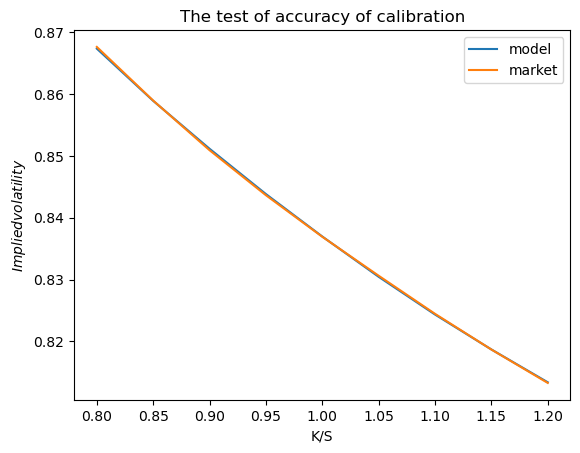

In [40]:
Ks = np.arange(80,122,5)
params = res.x

call_markets = np.array([call_frac(S0=100, K=Ks[i], T=1.5, rho=-0.75, H=0.3, c=0.5, ksi=1, a0=0.5) for i in range(len(Ks))]) 
call_models= np.array([call_frac(S0=100, K=Ks[i], T=1.5, rho=params[0], H=params[1], c=params[2], ksi=params[3], a0=params[4]) for i in range(len(Ks))])  
test_implied_vol(S0=100, T=1.5, Ks=Ks, call_models=call_models, call_markets=call_markets) 

In [29]:
data = pd.read_csv('../data/UnderlyingOptionsEODCalcs_2022-09-02.csv').head(1000)
data.rename(columns={'strike': 'K','implied_underlying_price_1545':'S0'}, inplace=True)
data = data[data['option_type']=='C']
data['T'] = (data["expiration"].map(lambda x: pd.Timestamp(x)) - data["quote_date"].map(lambda x: pd.Timestamp(x))).map(lambda x: int(x.days)/365.0)
data['call_markets'] = 0.5 * (data['bid_1545']+data['ask_1545'])

data = data[data['T']<1/12]
S0 = data['S0'].to_numpy()[0]
T = data['T'].to_numpy()[0]
data = data[data['T']==T]
data = data[data['S0']==S0]
data = data[np.abs((data["K"]-S0)/S0)<0.2]


Ks = data['K'].to_numpy()
call_markets = data['call_markets'].to_numpy()

res = calibration(Ks=Ks, y=call_markets, S0=S0, T=T)
print(res.x)
# print(call_markets)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.0413e+05                                    1.27e+06    
       1              2         8.4495e+04      1.96e+04       1.34e-01       5.21e+03    
       2              3         8.4469e+04      2.61e+01       4.28e-02       3.14e+02    
       3              5         8.4465e+04      3.33e+00       1.07e-01       2.37e+02    
       4              6         8.4460e+04      5.25e+00       2.00e-02       2.74e+02    
       5              8         8.4460e+04      2.75e-01       1.03e-02       7.23e+01    
       6             10         8.4460e+04      5.61e-02       2.68e-03       4.04e+01    
       7             11         8.4460e+04      1.08e-02       6.68e-04       8.63e+01    
       8             12         8.4460e+04      2.15e-02       4.64e-04       8.01e+00    
       9             13         8.4460e+04      1.34e-02       1.07e-03       1.10e+02    

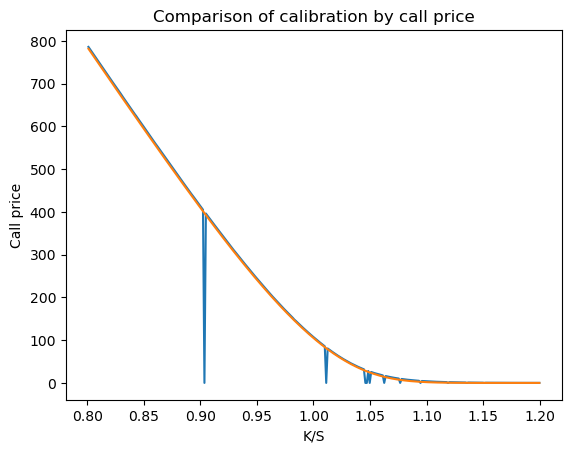

In [37]:
params = res.x


ST = sample_S_frac(S0=S0, T=T, rho=params[0], H=params[1], c=params[2], ksi=params[3], a0=params[4])[:,-1]
    
call_models = [np.mean(np.maximum(ST-Ks[i], 0))  for i in range(len(Ks))]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(Ks/S0, call_markets, "-")
ax.plot(Ks/S0, call_models, "-")

ax.set_xlabel("K/S")
ax.set_ylabel("Call price")
ax.set_title(f"Comparison of calibration by call price")
plt.show()

# test_implied_vol(S0=S0, T=T, Ks=Ks, call_models=call_models, call_markets=call_markets)    

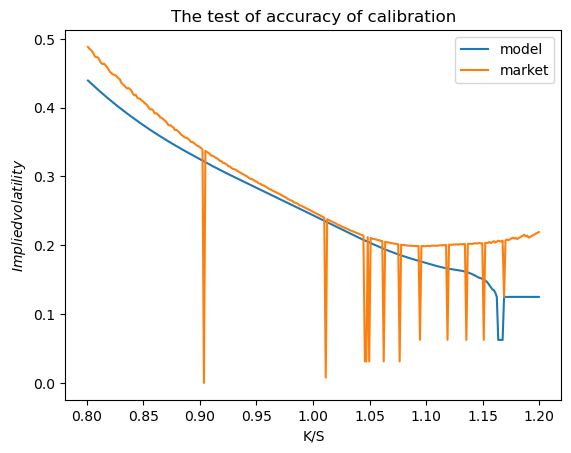

In [35]:
params = res.x


ST = sample_S_frac(S0=S0, T=T, rho=params[0], H=params[1], c=params[2], ksi=params[3], a0=params[4])[:,-1]
    
call_models = [np.mean(np.maximum(ST-Ks[i], 0))  for i in range(len(Ks))]
# call_models = np.zeros(len(Ks))
test_implied_vol(S0=S0, T=T, Ks=Ks, call_models=call_models, call_markets=call_markets) 

In [43]:
data = pd.read_csv('../data/UnderlyingOptionsEODCalcs_2022-09-02.csv').head(1000)
data.rename(columns={'strike': 'K','implied_underlying_price_1545':'S0'}, inplace=True)
data = data[data['option_type']=='C']
data['T'] = (data["expiration"].map(lambda x: pd.Timestamp(x)) - data["quote_date"].map(lambda x: pd.Timestamp(x))).map(lambda x: int(x.days)/365.0)
data['call_markets'] = 0.5 * (data['bid_1545']+data['ask_1545'])

data = data[data['T']<1/12]
S0 = data['S0'].to_numpy()[0]
T = data['T'].to_numpy()[0]
data = data[data['T']==T]
data = data[data['S0']==S0]
data = data[np.abs((data["K"]-S0)/S0)<0.2]


Ks = data['K'].to_numpy()
call_markets = data['call_markets'].to_numpy()

res = calibration(Ks=Ks, y=call_markets, S0=S0, T=T, loss=loss_2)
print(res)
# print(call_markets)

In [ ]:
params = res.x


ST = sample_S_frac(S0=S0, T=T, rho=params[0], H=params[1], c=params[2], ksi=params[3], a0=params[4])[:,-1]
    
call_models = [np.mean(np.maximum(ST-Ks[i], 0))  for i in range(len(Ks))]
# call_models = np.zeros(len(Ks))
test_implied_vol(S0=S0, T=T, Ks=Ks, call_models=call_models, call_markets=call_markets) 